In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

%matplotlib inline

### Functions

In [2]:
def encoder(dataset, catFeatures, qtyFeatures):
  dataset = dataset[catFeatures + qtyFeatures]
  dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
  return(dataset_encoded)

def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

def print_accurcay_metrics(model, X, y, threshold):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  y_pred_class = binarize([y_pred_prob], threshold)[0]
  
  print("Accurcay:", accuracy_score(y, y_pred_class))
  print("AUC:", roc_auc_score(y, y_pred_prob))
  print("Log Loss:", log_loss(y, y_pred_prob))
  print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
  print("Recall:", recall_score(y, y_pred_class))
  print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
  fpr, tpr, threshold = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)
  
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

  ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)

  plt.tight_layout()
  plt.show()

### Determine the number of fraud and valid transactions in the datase

In [70]:
Fraud = df[df['Class']==1]
Valid = df[df['Class']==0]
print("Number of fraud transactions: ",len(Fraud.index))
print("Number of valid Transactions: ",len(Valid.index))

Number of fraud transactions:  422
Number of valid Transactions:  244385


### Amount per transaction by Fraud and Valid Transactions

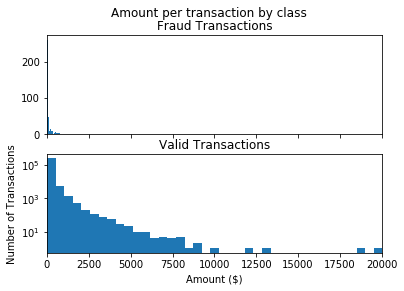

In [73]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud Transactions')
ax2.hist(Valid.Amount, bins = bins)
ax2.set_title('Valid Transactions')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### Transactions vs TimeFrame

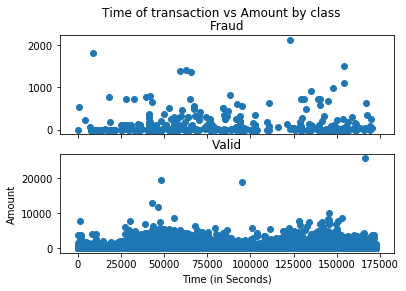

In [74]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Valid.Time, Valid.Amount)
ax2.set_title('Valid')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'xlim'

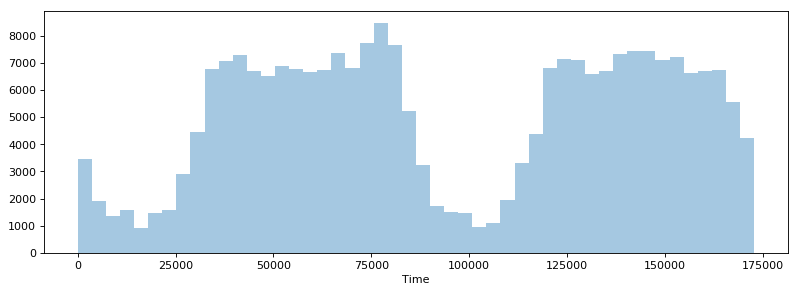

In [88]:
import seaborn as sb
import matplotlib as plt
plt.pyplot.figure(figsize=(12,4), dpi=80)
sb.distplot(df.Time, bins=48, kde=False)
plt.xlim([0,50])
plt.pyplot.xticks(np.arange(0,54,6))
plt.xlabel('Time After First Transaction (hr)')
plt.ylabel('Count')
plt.pyplot.title('Transaction Times')
# the two heaps shows that maximum transactions have happened during the night time.

### Transaction Amount and Time Distributions

C:\Users\nisha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


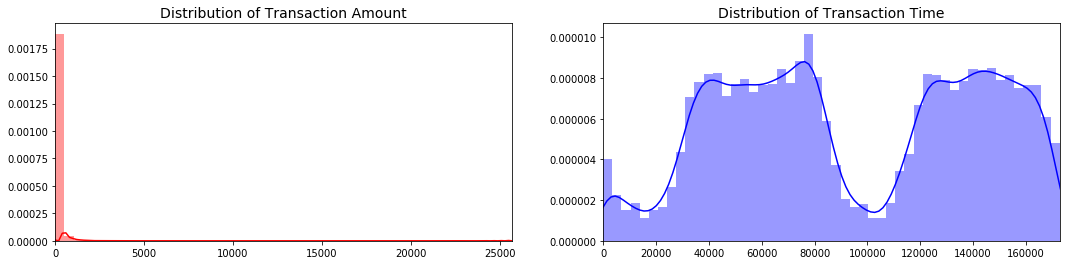

In [78]:
fig, ax = plt.pyplot.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.pyplot.show()

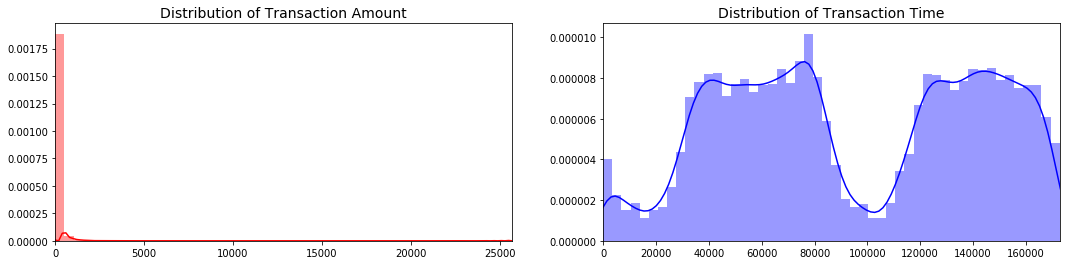

In [89]:
fig, ax = plt.pyplot.subplots(1, 2, figsize=(18,4))

amount_val = tempdf['Amount'].values
time_val = tempdf['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.pyplot.show()

#### Import the dataset as df and test dataset as 'test_df'

In [3]:
df = pd.read_csv('creditcard_dataset.csv')
test_df = pd.read_csv('creditcard_test_dataset.csv')

In [79]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
117814,72411.0,0.222590,-1.238916,0.022264,1.902889,-0.739166,0.224873,0.320594,-0.015400,0.638668,...,-0.520191,0.066358,0.463742,-0.299118,0.006558,0.130806,471.63,0,6.293813,-0.144689
35897,163821.0,2.072694,-0.019852,-1.116642,0.377287,-0.029352,-1.118054,0.214408,-0.352921,0.478861,...,0.316048,-0.097205,-0.262504,0.203454,-0.067820,-0.060369,1.98,0,-0.280235,0.927462
36488,2893.0,-1.622210,-0.453055,0.950034,-0.278592,1.430375,-1.367408,0.144985,-0.121981,0.215440,...,0.285658,-0.087583,-0.826208,-0.198808,0.012548,0.157743,1.78,0,-0.283035,-0.960068
243400,120799.0,2.100859,-0.040931,-1.898974,0.446334,0.541394,-0.789385,0.423152,-0.306270,0.470164,...,0.070023,0.504320,0.251765,0.364214,-0.094034,-0.070514,10.92,0,-0.155095,0.422855
125479,124872.0,0.337604,-3.484022,-1.652439,-0.125336,-1.598151,-0.307795,0.506596,-0.214990,1.565995,...,-0.340718,0.684602,-0.979113,0.214015,-0.221021,0.112968,900.00,0,12.290034,0.470628


In [80]:
tempdf =  pd.read_csv('creditcard_dataset.csv')

### Checking for duplicate rows

In [81]:
duplicateRowsDF = tempdf[tempdf.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [id, Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class]
Index: []

[0 rows x 32 columns]


In [82]:
# Select all duplicate rows based on all column except id
duplicateRowsDF = tempdf[tempdf.duplicated(['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9',
            'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22',
           'V23','V24','V25','V26','V27','V28','Amount'])]
 
print("Duplicate Rows based on a all column are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on a single column are:
            id      Time        V1        V2         V3        V4        V5  \
2529    134796   68780.0  0.488552 -0.922367   1.673494  3.003203 -1.465758   
9192     65947  163152.0 -1.203617  1.574009   2.889277  3.381404  1.538663   
10790   217727  159888.0 -3.146402  2.543688  -0.328957  2.499684 -0.112949   
13777   126920   68780.0  0.416937 -1.040707   1.631927  3.033315 -1.502318   
14019   162862   88759.0  1.918275  0.666212  -0.882650  3.500924  0.804717   
15953   277551  112486.0 -3.681910 -1.509883  -1.617267  1.116832  2.645200   
20750   127512  163152.0 -1.196037  1.585949   2.883976  3.378471  1.511706   
22160    45075  120910.0  2.010962 -0.073225  -1.204314  0.436129  0.053113   
23809   103346   31964.0  1.202754  0.395072   0.233037  1.237243 -0.012361   
23903    61452   36541.0 -5.087717  3.095231   0.601791  0.744861 -0.998968   
24988   275853  163152.0 -1.203617  1.574009   2.889277  3.381404  1.538663   
27331  

Distribution of the Classes in the original dataset
0    0.998276
1    0.001724
Name: Class, dtype: float64


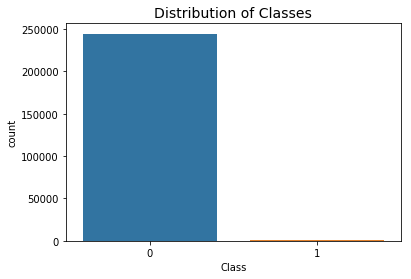

In [85]:
print('Distribution of the Classes in the original dataset')
print(tempdf['Class'].value_counts()/len(df))
sns.countplot('Class', data=tempdf)
plt.pyplot.title('Distribution of Classes', fontsize=14)
plt.pyplot.show()

In [5]:
# Check for null values
df.isnull().values.any()

False

In [6]:
# Drop 'id' column in the dataframe
df = df.drop(['id'], axis=1)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,58670.0,-0.854092,0.644458,1.805656,1.146369,-0.519127,1.844676,-0.935942,1.056104,0.097375,...,0.193673,0.789467,0.218834,-0.577043,-0.727521,0.612977,-0.219109,-0.063157,11.50,0
1,164361.0,-0.863534,0.291699,0.594479,-1.190707,0.117851,0.169880,0.065587,0.289947,-1.748278,...,-0.223345,-0.333300,-0.455269,0.185385,0.432974,0.931127,-0.414413,-0.284978,25.42,0
2,38767.0,-1.192107,-0.896044,1.204410,-1.593935,0.432699,-1.101769,-0.299815,0.222793,-1.320361,...,0.470749,0.932440,0.159099,0.215700,-0.169315,-0.320951,0.310243,0.210535,58.75,0
3,571.0,-2.355336,2.316182,0.701735,0.174501,0.677346,1.029705,0.792868,-0.060581,1.296525,...,0.008872,0.955806,0.047292,-0.650140,-0.282282,-0.286391,0.335493,0.223061,2.89,0
4,51507.0,-1.302336,1.016359,1.007046,-0.127051,0.435740,-0.092143,0.709650,0.590142,-1.088295,...,0.150091,0.059446,-0.262177,-0.354871,0.680078,-0.402172,-0.111834,-0.044427,51.59,0


In [8]:
# Create two columns called as 'scaled_time' and 'scaled_amount'
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,58670.0,-0.854092,0.644458,1.805656,1.146369,-0.519127,1.844676,-0.935942,1.056104,0.097375,...,0.218834,-0.577043,-0.727521,0.612977,-0.219109,-0.063157,11.50,0,-0.146976,-0.305858
1,164361.0,-0.863534,0.291699,0.594479,-1.190707,0.117851,0.169880,0.065587,0.289947,-1.748278,...,-0.455269,0.185385,0.432974,0.931127,-0.414413,-0.284978,25.42,0,0.047872,0.933795
2,38767.0,-1.192107,-0.896044,1.204410,-1.593935,0.432699,-1.101769,-0.299815,0.222793,-1.320361,...,0.159099,0.215700,-0.169315,-0.320951,0.310243,0.210535,58.75,0,0.514418,-0.539301
3,571.0,-2.355336,2.316182,0.701735,0.174501,0.677346,1.029705,0.792868,-0.060581,1.296525,...,0.047292,-0.650140,-0.282282,-0.286391,0.335493,0.223061,2.89,0,-0.267497,-0.987303
4,51507.0,-1.302336,1.016359,1.007046,-0.127051,0.435740,-0.092143,0.709650,0.590142,-1.088295,...,-0.262177,-0.354871,0.680078,-0.402172,-0.111834,-0.044427,51.59,0,0.414194,-0.389873


In [10]:
# Now perform the same operations on the test dataset
test_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,-0.437585,0.211402,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,-1.351008,-0.202483,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.617074,-0.255027,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.457894,0.498576,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.175248,-0.238352,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00


In [11]:
test_df.shape

(40000, 31)

In [12]:
# Check for null values in the test dataset
test_df.isnull().values.any()

False

In [11]:
# Drop 'id' column in the test_dataframe
#test_df = test_df.drop(['id'], axis=1)
#Not done

In [13]:
test_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,-0.437585,0.211402,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,-1.351008,-0.202483,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.617074,-0.255027,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.457894,0.498576,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.175248,-0.238352,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00


In [14]:
# Create two columns called as 'scaled_time' and 'scaled_amount' in test_dataset
# RobustScaler is less prone to outliers.
test_df['scaled_amount'] = rob_scaler.fit_transform(test_df['Amount'].values.reshape(-1,1))
test_df['scaled_time'] = rob_scaler.fit_transform(test_df['Time'].values.reshape(-1,1))

In [15]:
test_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,scaled_amount,scaled_time
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00,-0.290778,0.300271
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48,4.312933,0.002449
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14,0.389643,0.135572
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04,3.212960,0.682814
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00,-0.290778,0.527779


In [16]:
# Define feature arrays

features = ['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9',
            'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22',
           'V23','V24','V25','V26','V27','V28','Amount']

scaled_features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
            'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22',
           'V23','V24','V25','V26','V27','V28','scaled_amount','scaled_time']

## Now train, valid and test on the original data with all features and scaled_features (2 Models) without any undersampling or oversampling

In [17]:
# Model1 :- with Original features

y = df['Class']
X = df[features]

In [18]:
X_train, X_testing, y_train, y_testing = train_test_split(X, y, test_size = 0.3, random_state = 16)

In [19]:
X_valid, X_test, y_valid, y_test = train_test_split(X_testing, y_testing, test_size = 0.5, random_state = 31)

In [20]:
print('Shape of X_train: ',X_train.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of X_valid: ',X_valid.shape)
print('Shape of y_valid: ',y_valid.shape)
print('Shape of X_test: ',X_test.shape)
print('Shape of y_test: ',y_test.shape)

Shape of X_train:  (171364, 30)
Shape of y_train:  (171364,)
Shape of X_valid:  (36721, 30)
Shape of y_valid:  (36721,)
Shape of X_test:  (36722, 30)
Shape of y_test:  (36722,)


Distribution of the Classes in the original dataset
0    0.998276
1    0.001724
Name: Class, dtype: float64


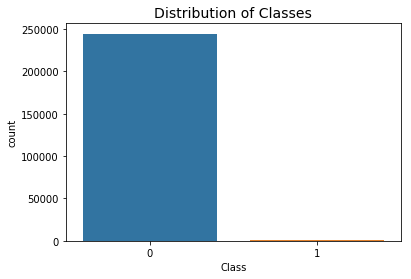

In [21]:
print('Distribution of the Classes in the original dataset')
print(df['Class'].value_counts()/len(df))
sns.countplot('Class', data=df)
plt.title('Distribution of Classes', fontsize=14)
plt.show()

### It is a highly imbalanced dataset. Fit a model and test it

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimal Cutoff: [0.00201228]
Accurcay: 0.9988290398126464
AUC: 0.8801202857997642
Log Loss: 0.010948375220051265
Confusion Matrix:
 [[36647    13]
 [   30    32]]
Recall: 0.5161290322580645
Precision: 0.7111111111111111


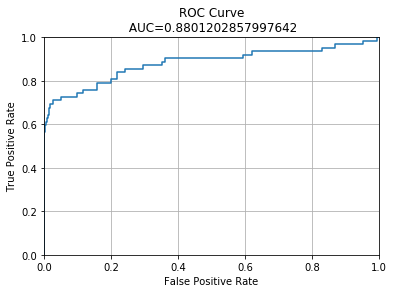

In [22]:
logreg = LogisticRegression()
model_training(logreg, X_train, y_train)

#threshold = 0.5
plot_auc_curve(logreg, X_test, y_test)
Find_Optimal_Cutoff(logreg, X_test, y_test)
print_accurcay_metrics(logreg, X_test, y_test, 0.50)

In [23]:
# threshold = 0.7
print_accurcay_metrics(logreg, X_test, y_test, 0.70)

Accurcay: 0.9989379663417025
AUC: 0.8801202857997642
Log Loss: 0.010948375220051265
Confusion Matrix:
 [[36654     6]
 [   33    29]]
Recall: 0.46774193548387094
Precision: 0.8285714285714286


In [24]:
# threshold = 0.9
print_accurcay_metrics(logreg, X_test, y_test, 0.9)

Accurcay: 0.9988835030771744
AUC: 0.8801202857997642
Log Loss: 0.010948375220051265
Confusion Matrix:
 [[36656     4]
 [   37    25]]
Recall: 0.4032258064516129
Precision: 0.8620689655172413


### Train on original dataset including all features and scaling time and amount

In [25]:
y1 = df['Class']
X1 = df[scaled_features]

In [26]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 34)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimal Cutoff: [0.00140329]
Accurcay: 0.9992647359176504
AUC: 0.9885953466259011
Log Loss: 0.0033605409911763107
Confusion Matrix:
 [[48876     7]
 [   29    50]]
Recall: 0.6329113924050633
Precision: 0.8771929824561403


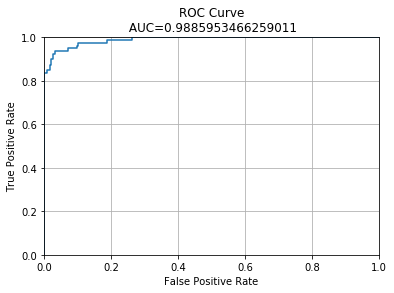

In [27]:
model_training(logreg, X1_train, y1_train)

#threshold = 0.5
plot_auc_curve(logreg, X1_test, y1_test)
Find_Optimal_Cutoff(logreg, X1_test, y1_test)
print_accurcay_metrics(logreg, X1_test, y1_test, 0.50)

In [28]:
#threshold = 0.8
print_accurcay_metrics(logreg, X1_test, y1_test, 0.8)

Accurcay: 0.9991830399085004
AUC: 0.9885953466259011
Log Loss: 0.0033605409911763107
Confusion Matrix:
 [[48878     5]
 [   35    44]]
Recall: 0.5569620253164557
Precision: 0.8979591836734694


In [29]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X1_train, y1_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default s

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
print(log_reg)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


## Undersampling. Train, Valid on undersampling(50 percent valid transactions and 50 percent valid transactions) data and test on original data. Consider all features with scaled time and scaled amount and then some features using heatmap

In [31]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,58670.0,-0.854092,0.644458,1.805656,1.146369,-0.519127,1.844676,-0.935942,1.056104,0.097375,...,0.218834,-0.577043,-0.727521,0.612977,-0.219109,-0.063157,11.50,0,-0.146976,-0.305858
1,164361.0,-0.863534,0.291699,0.594479,-1.190707,0.117851,0.169880,0.065587,0.289947,-1.748278,...,-0.455269,0.185385,0.432974,0.931127,-0.414413,-0.284978,25.42,0,0.047872,0.933795
2,38767.0,-1.192107,-0.896044,1.204410,-1.593935,0.432699,-1.101769,-0.299815,0.222793,-1.320361,...,0.159099,0.215700,-0.169315,-0.320951,0.310243,0.210535,58.75,0,0.514418,-0.539301
3,571.0,-2.355336,2.316182,0.701735,0.174501,0.677346,1.029705,0.792868,-0.060581,1.296525,...,0.047292,-0.650140,-0.282282,-0.286391,0.335493,0.223061,2.89,0,-0.267497,-0.987303
4,51507.0,-1.302336,1.016359,1.007046,-0.127051,0.435740,-0.092143,0.709650,0.590142,-1.088295,...,-0.262177,-0.354871,0.680078,-0.402172,-0.111834,-0.044427,51.59,0,0.414194,-0.389873


In [32]:
print('Valid transactions: ', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraud transactions: ', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Valid transactions:  99.83 % of the dataset
Fraud transactions:  0.17 % of the dataset


### Splitting the original dataframe to train and test set. Training will be done on undersampled data while testing will be done on the original data. The original data consists of 99.83% of valid transactions and 0.17% of fraud transactions. While splitting the original dataframe, the train and test set should also constitute the same percent of transactions that is, train and test should contain 99.83% of valid transactions and 0.17% of fraud transactions

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df[scaled_features]
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [184623  97995  61984 ... 175474  76784 227996] Test: [166702  94440  52262 ...  20546 112619  55182]
Train: [ 67075 144760 206794 ... 243879 138567 228701] Test: [ 36042 134045   2607 ... 108669 211559 206099]
Train: [240586 173314 237080 ... 213303 138286 209048] Test: [149240 185126 146539 ... 220737 133447  46881]
Train: [ 21344 174936  35580 ... 233500 240506  76344] Test: [188970  43725 194649 ... 190579 105042 180161]
Train: [163777 116355 179181 ...  96973  28549 135673] Test: [221422 232206 205998 ...  20636  62768  99196]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827415 0.00172585]
[0.99828438 0.00171562]


### Classes are highly skewed. We should make them equivalent in order to have a normal distribution of the classes. Shuffle the data before creating the subsamples 

In [34]:
df = df.sample(frac=1)

# amount of fraud classes 422 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:422]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
189382,123157.0,-0.796959,0.036784,0.300988,-4.038641,2.431153,3.417907,-0.014249,1.046442,0.884941,...,-0.224031,0.681166,0.495107,-0.500328,0.049960,0.052241,9.15,0,-0.179871,0.450512
241486,50808.0,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,-2.412987,...,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,99.99,1,1.091685,-0.398072
229150,86712.0,-0.224925,0.836681,0.314169,-0.717730,0.871523,-1.203708,1.282224,-0.635885,0.089081,...,-0.282279,0.027950,-0.469168,-0.296015,-0.234460,0.020326,0.76,0,-0.297312,0.023048
136569,16259.0,1.260486,-0.040965,0.255463,0.717141,-0.021404,0.419794,-0.410296,0.091152,1.864156,...,-0.224961,-0.850153,0.655915,0.456968,-0.054734,-0.018903,9.99,0,-0.168113,-0.803298
95815,78725.0,-4.312479,1.886476,-2.338634,-0.475243,-1.185444,-2.112079,-2.122793,0.272565,0.290273,...,-1.114692,0.269069,-0.020572,-0.963489,-0.918888,0.001454,60.00,1,0.531915,-0.070632


In [35]:
new_df.shape

(844, 33)

Distribution of the Classes in the subsample(undersampled) dataset
1    0.5
0    0.5
Name: Class, dtype: float64


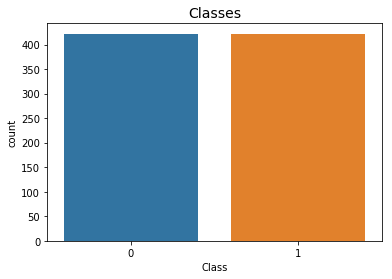

In [36]:
print('Distribution of the Classes in the subsample(undersampled) dataset')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df)
plt.title('Classes', fontsize=14)
plt.show()

## Correlation Matrices

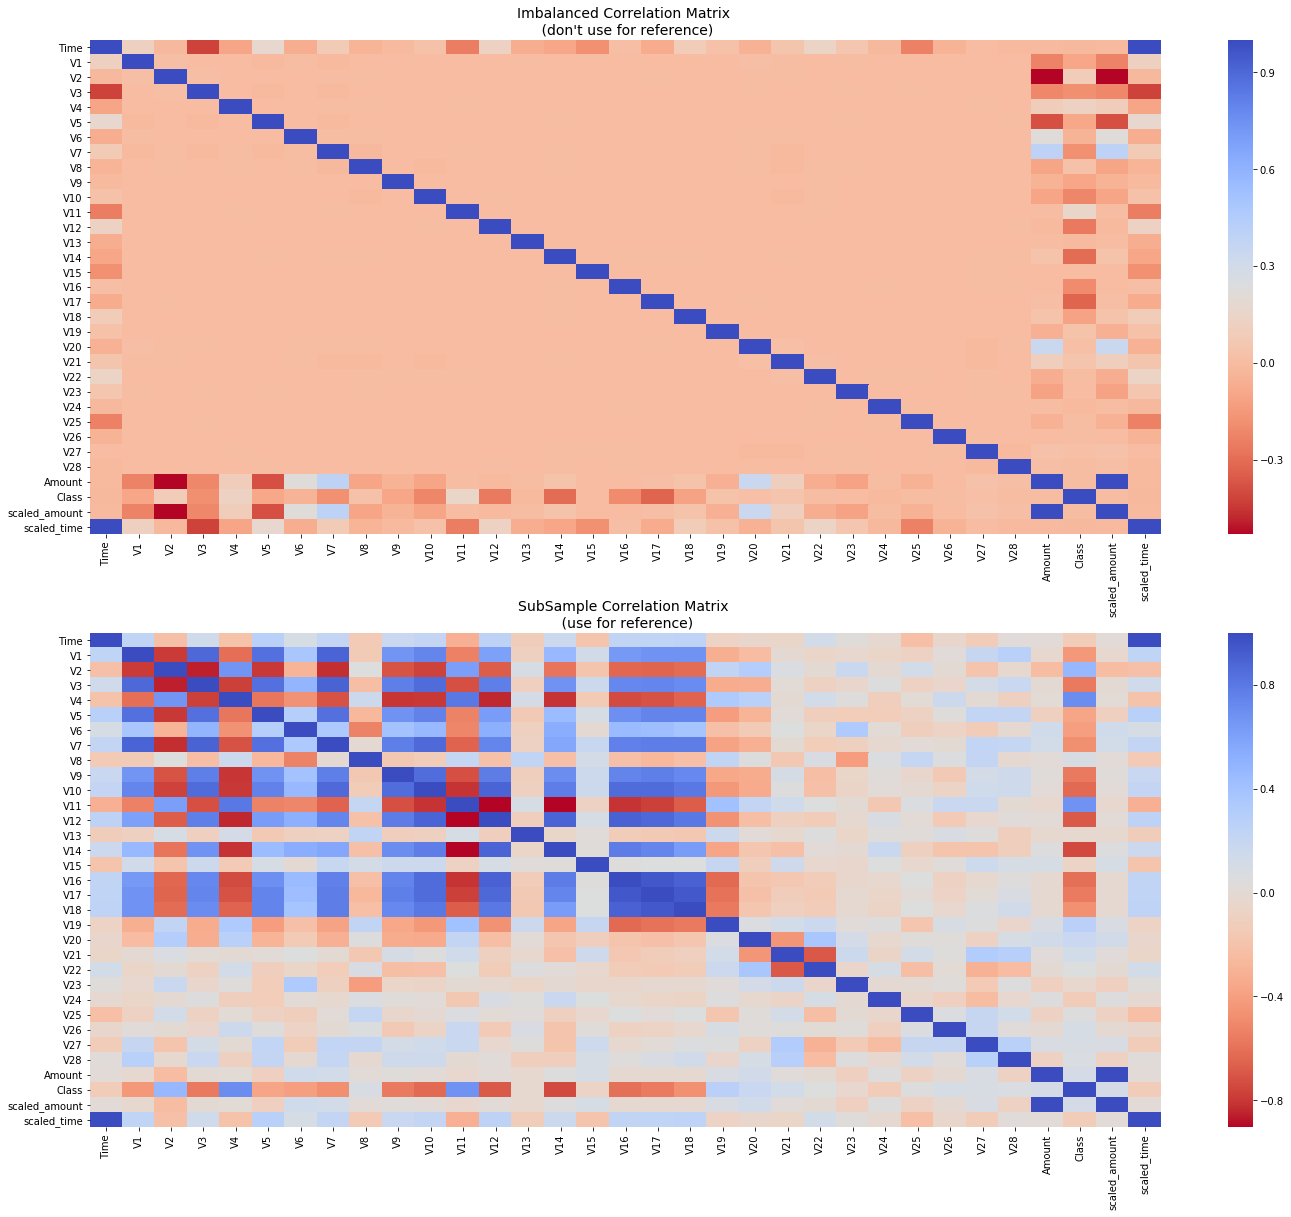

In [37]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### Strong Negative correlation: V10, V12, V14, V16, V17     Positive correlation: V2, V4, V11, V19 Now plot boxplots for relation between the features and the Class

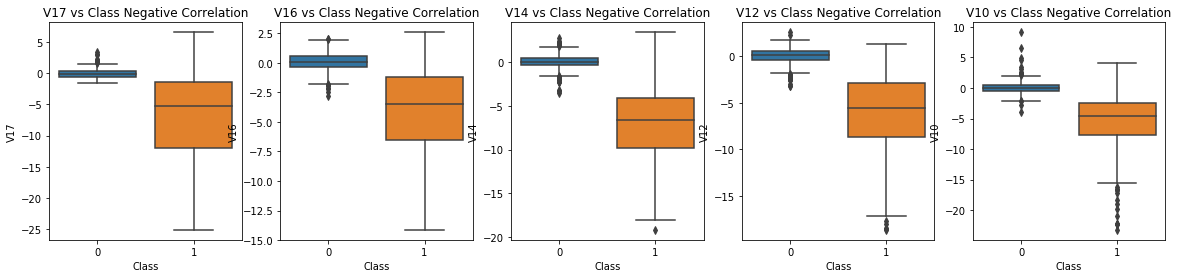

In [38]:
f, axes = plt.subplots(ncols=5, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=new_df, ax=axes[1])
axes[1].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[2])
axes[2].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[3])
axes[3].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[4])
axes[4].set_title('V10 vs Class Negative Correlation')

plt.show()

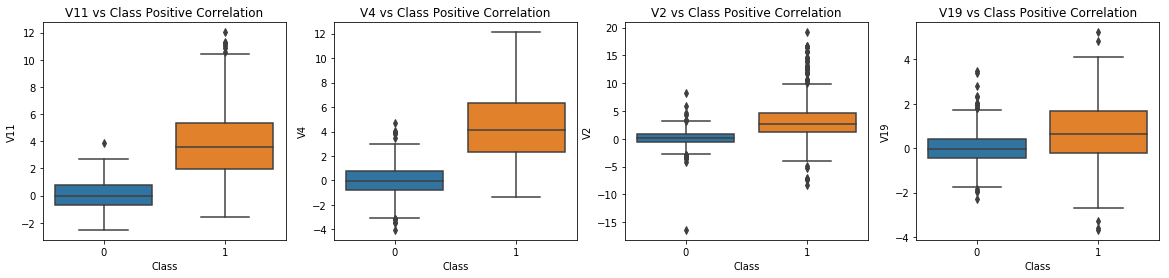

In [39]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

C:\Users\nisha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


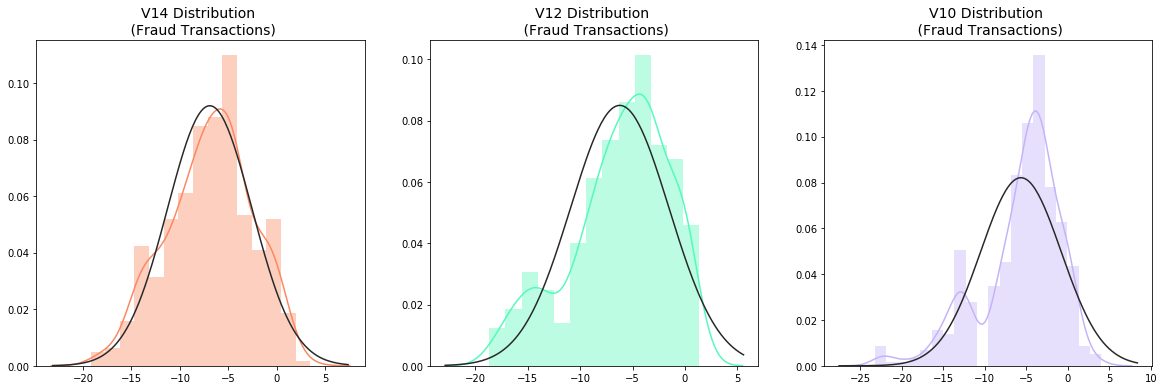

In [40]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

## Outliers haven't been removed yet. Undersampling

In [41]:
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
189382,123157.0,-0.796959,0.036784,0.300988,-4.038641,2.431153,3.417907,-0.014249,1.046442,0.884941,...,-0.224031,0.681166,0.495107,-0.500328,0.049960,0.052241,9.15,0,-0.179871,0.450512
241486,50808.0,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,-2.412987,...,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,99.99,1,1.091685,-0.398072
229150,86712.0,-0.224925,0.836681,0.314169,-0.717730,0.871523,-1.203708,1.282224,-0.635885,0.089081,...,-0.282279,0.027950,-0.469168,-0.296015,-0.234460,0.020326,0.76,0,-0.297312,0.023048
136569,16259.0,1.260486,-0.040965,0.255463,0.717141,-0.021404,0.419794,-0.410296,0.091152,1.864156,...,-0.224961,-0.850153,0.655915,0.456968,-0.054734,-0.018903,9.99,0,-0.168113,-0.803298
95815,78725.0,-4.312479,1.886476,-2.338634,-0.475243,-1.185444,-2.112079,-2.122793,0.272565,0.290273,...,-1.114692,0.269069,-0.020572,-0.963489,-0.918888,0.001454,60.00,1,0.531915,-0.070632


In [42]:
X2 = new_df[scaled_features]
y2 = new_df['Class']

In [43]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [44]:
logreg = LogisticRegression()
model_training(logreg, X2_train, y2_train)

#threshold = 0.5
'''
plot_auc_curve(logreg, X2_test, y2_test)
Find_Optimal_Cutoff(logreg, X2_test, y2_test)
print_accurcay_metrics(logreg, X2_test, y2_test, 0.50)
'''

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'\nplot_auc_curve(logreg, X2_test, y2_test)\nFind_Optimal_Cutoff(logreg, X2_test, y2_test)\nprint_accurcay_metrics(logreg, X2_test, y2_test, 0.50)\n'

In [45]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X2_train, y2_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_
print(log_reg)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default s

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
newlogreg = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimal Cutoff: [0.31119537]
Accurcay: 0.9112426035502958
AUC: 0.9581930415263749
Log Loss: 0.22435055089479783
Confusion Matrix:
 [[86  2]
 [13 68]]
Recall: 0.8395061728395061
Precision: 0.9714285714285714


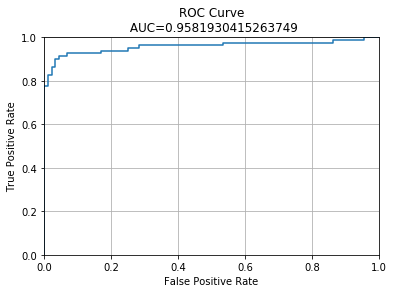

In [47]:
model_training(newlogreg, X2_train, y2_train)
plot_auc_curve(newlogreg, X2_test, y2_test)
Find_Optimal_Cutoff(newlogreg, X2_test, y2_test)
print_accurcay_metrics(newlogreg, X2_test, y2_test, 0.50)

#### Now test on the original dataset i.e original_Xtest, original_ytest

Optimal Cutoff: [0.33215867]
Accurcay: 0.9709162207426167
AUC: 0.9786721165818102
Log Loss: 0.16636557429138865
Confusion Matrix:
 [[47462  1416]
 [    8    76]]
Recall: 0.9047619047619048
Precision: 0.05093833780160858


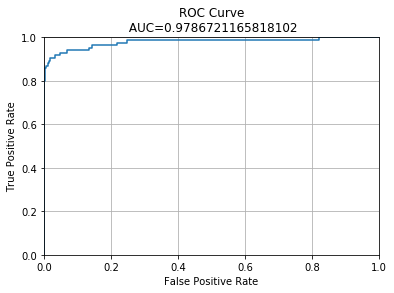

In [48]:
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.50)

Optimal Cutoff: [0.33215867]
Accurcay: 0.9921980311261794
AUC: 0.9786721165818102
Log Loss: 0.16636557429138865
Confusion Matrix:
 [[48507   371]
 [   11    73]]
Recall: 0.8690476190476191
Precision: 0.16441441441441443


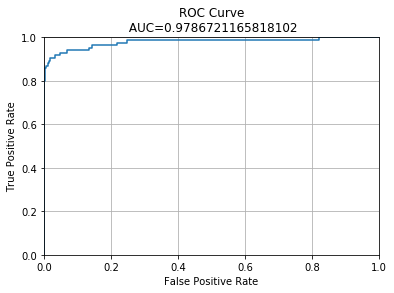

In [49]:
#threshold = 0.75
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.75)

Optimal Cutoff: [0.33215867]
Accurcay: 0.9971814876843266
AUC: 0.9786721165818102
Log Loss: 0.16636557429138865
Confusion Matrix:
 [[48753   125]
 [   13    71]]
Recall: 0.8452380952380952
Precision: 0.3622448979591837


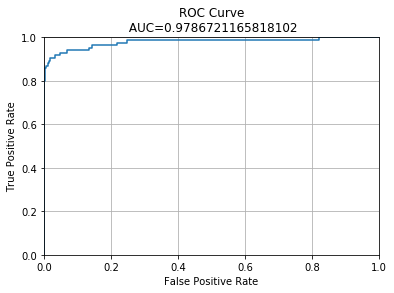

In [50]:
#threshold = 0.9
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.9)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimal Cutoff: [0.00125485]
Accurcay: 0.999203463910788
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48870     8]
 [   31    53]]
Recall: 0.6309523809523809
Precision: 0.8688524590163934


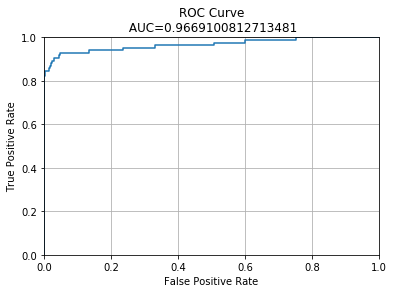

In [51]:
model_training(newlogreg, original_Xtrain, original_ytrain)
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.50)

Optimal Cutoff: [0.00125485]
Accurcay: 0.9991013438993506
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48870     8]
 [   36    48]]
Recall: 0.5714285714285714
Precision: 0.8571428571428571


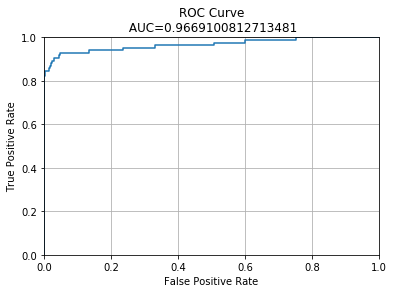

In [52]:
#model_training(newlogreg, X2_train, y2_train)
#threshold = 0.75
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.75)

Optimal Cutoff: [0.00125485]
Accurcay: 0.9991830399085004
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48864    14]
 [   26    58]]
Recall: 0.6904761904761905
Precision: 0.8055555555555556


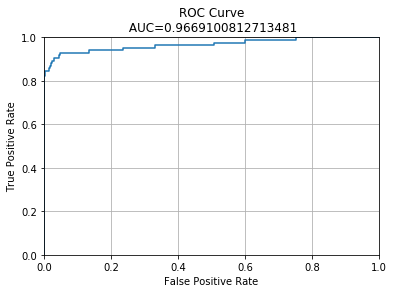

In [53]:
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest)

Optimal Cutoff: [0.00125485]
Accurcay: 0.9992443119153629
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48861    17]
 [   20    64]]
Recall: 0.7619047619047619
Precision: 0.7901234567901234


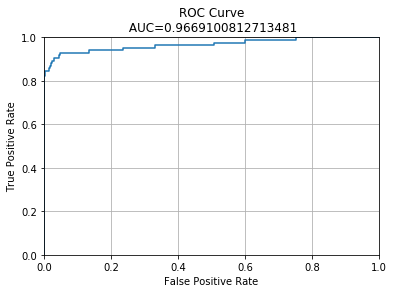

In [54]:
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.15)

Optimal Cutoff: [0.00125485]
Accurcay: 0.999203463910788
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48858    20]
 [   19    65]]
Recall: 0.7738095238095238
Precision: 0.7647058823529411


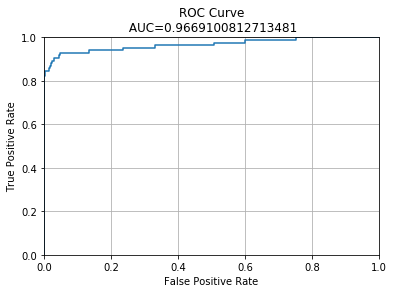

In [55]:
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.10)

Optimal Cutoff: [0.00125485]
Accurcay: 0.9992443119153629
AUC: 0.9669100812713481
Log Loss: 0.004406989376127361
Confusion Matrix:
 [[48861    17]
 [   20    64]]
Recall: 0.7619047619047619
Precision: 0.7901234567901234


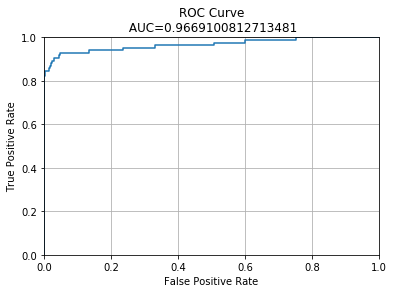

In [59]:
plot_auc_curve(newlogreg, original_Xtest, original_ytest)
Find_Optimal_Cutoff(newlogreg, original_Xtest, original_ytest)
print_accurcay_metrics(newlogreg, original_Xtest, original_ytest, 0.15)

In [60]:
import pickle
filename = 'ccmodel1.sav'
pickle.dump(newlogreg, open(filename, 'wb'))

In [62]:
test_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,scaled_amount,scaled_time
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00,-0.290778,0.300271
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48,4.312933,0.002449
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14,0.389643,0.135572
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04,3.212960,0.682814
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00,-0.290778,0.527779


In [63]:
test1 = test_df[scaled_features]

In [64]:
y_pred = newlogreg.predict(test1)
print(y_pred)

[0 0 0 ... 0 0 0]


In [68]:
prediction = pd.DataFrame(y_pred, columns=['predicted_class']).to_csv('cc_prediction_fin.csv')

In [ ]:
# rANDOM Forests
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf= RandomForestClassifier(n_estimators=100)# here we are just changing classifier
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")

In [69]:
# Oversampling

df = pd.read_csv('creditcard_dataset.csv')
df_features = df.drop('Class', axis = 1)
df_labels = df['Class']


def PyAugOversampling():
    #Scale DataFrame.
    df_scaled = StandardScaler().fit_transform(df_features).reshape(-1, 30) # Reshape the NumPy array. 
    df_scaled = pd.DataFrame(df_scaled, columns = df_features.columns.values)

    #Concatenate Scaled DataFrame with Unscaled Labels.
    df_scaled = pd.concat([df_scaled, df_labels], axis = 1)

    df_class0 = df_scaled.loc[df_scaled['Class'] == 0] #Extract Class = 0 (Non-Fraud).
    df_class0 = df_class0.sample(2000) #Take Random Sample of 2000.
    df_class1 = df_scaled.loc[df_scaled['Class'] == 1] #Extract Class = 1 (Fraud).

    #Define Features and Targets for Class 0 and Class 1.
    X0 = df_class0.drop('Class', axis = 1) #Remove target feature.
    y0 = df_class0['Class']

    X1 = df_class1.drop('Class', axis = 1) #Remove target feature.
    y1 = df_class1['Class']

    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size = 0.5, random_state = 0)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.5, random_state = 0)


    Xtrain1_ytrain1_concat = pd.concat([X_train1, y_train1], axis = 1) #Concatenate X_train1 and y_train1 to augment 1000 news rows.
    aug_train1 = PyAugLinear(Xtrain1_ytrain1_concat, 1000, 3, ['Class']) #Generate 1000 synthetic results using PyAug.

    aug_train1_features = aug_train1.drop('Class', axis = 1) #Remove target feature.
    aug_train1_class = aug_train1['Class']

    X_train = pd.concat([X_train0, aug_train1_features], axis = 0) #Concatenate X_train0 and aug_train1_features.
    y_train = pd.concat([y_train0, aug_train1_class], axis = 0) #Concatenate y_train0 and aug_train1_class.

    X_test = pd.concat([X_test0.sample(len(X_test1)), X_test1], axis = 0) #Make Sure Sample size correct
    y_test = pd.concat([y_test0.sample(len(y_test1)), y_test1], axis = 0) #Make Sure Sample size correct


    #Machine Learning.
    lr = LogisticRegression(C = 1e5, solver = 'liblinear') # Initiate LogisticRegression model.
    lr.fit(X_train, y_train) # Fit the LogisticRegression model.
    y_pred = lr.predict(X_test) # Predict y_pred values using X_test features.

    
    #Assess Machine Learning Model.
    results_matrix = confusion_matrix(y_test, y_pred)
    accuracyscore = float('%.3f' % accuracy_score(y_test, y_pred))
    ROCAUCscore =  float('%.3f' % roc_auc_score(y_test, y_pred))
    recallscore = float('%.3f' % recall_score(y_test, y_pred))
    
    metrics = [accuracyscore, ROCAUCscore, recallscore]
    return metrics


#Iterating and Evaluating Average Metrics.
iteration_results_oversampling = []
for _ in range(10):
    iteration_results_oversampling.append(PyAugOversampling())
 
PyAug_df = pd.DataFrame(iteration_results_oversampling, columns = ['Accuracy', 'ROCAUC', 'Recall'])

average_accuracy_oversampling = PyAug_df['Accuracy'].mean()
average_ROCAUC_oversampling = PyAug_df['ROCAUC'].mean()
average_recall_oversampling = PyAug_df['Recall'].mean()

print(PyAug_df.head())
print('Average Accuracy', float('%.3f' % average_accuracy_oversampling))
print('Average ROCAUC', float('%.3f' % average_ROCAUC_oversampling))
print('Average Recall', float('%.3f' % average_recall_oversampling))